In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import MySQLdb as mdb
# from definitions import DATABASE_CONFIG_DIR, INCOME_STATEMENT_DIR

## load stock info

In [4]:
with open('../../database/database_config/database.ymal') as f:
    db_config = yaml.load(f, Loader=yaml.FullLoader)
db = mdb.connect(host=db_config['db_host'], user=db_config['db_user'], passwd=db_config['db_pass'],
                 db=db_config['db_name'], use_unicode=True, charset="utf8")
# select stockId and ticker from table stock_info
table_name = 'stock_info'
column_list = ['stockId', 'ticker', 'IndustryGroup']
columns = ','.join(column_list)
req = """SELECT %s FROM %s WHERE sp500=TRUE """ % (columns, table_name)
get_stock_info_cursor = db.cursor()
get_stock_info_cursor.execute(req)
stock_info = get_stock_info_cursor.fetchall()
get_stock_info_cursor.close()

#create dataframe
df_stock_info = pd.DataFrame(stock_info, columns=column_list)

In [5]:
df_stock_info.head(5)

,stockId,ticker,IndustryGroup
0,11,PNR,Machinery
1,37,ALLE,Building Materials
2,45,ITW,Machinery
3,48,AMAT,Semiconductor Equip
4,52,NWL,Household Products


## load the file

In [6]:
file = '../20210419_valuation_result_sp500.csv'
df_valuation = pd.read_csv(file)

In [7]:
df_valuation.head(5)

,ticker,current_price,estimated_value,price_to_value
0,PNR,63.84,34.179709,1.867775
1,ALLE,133.01,78.805437,1.687828
2,ITW,224.03,131.852585,1.699094
3,AMAT,133.73,101.693333,1.315032
4,NWL,26.76,13.761117,1.944610


In [8]:
df_valuation.describe()

,current_price,estimated_value,price_to_value
count,490.000000,488.000000,488.000000
mean,182.919337,-508.173572,7.765229
std,329.296826,8297.267059,143.853378
min,10.530000,-152858.438392,-510.109738
25%,61.617500,20.310053,0.805873
50%,111.895000,62.306402,1.462536
75%,207.135000,121.213742,2.374598
max,4984.850000,5973.610831,3080.667022


## merge two dataframes

In [9]:
df = pd.merge(df_valuation, df_stock_info, left_on='ticker', right_on='ticker', how='left')

In [10]:
## filter out finanace sector 
df = df.loc[(df['IndustryGroup']!='Financial Svcs. (Non-bank & Insurance)')
                 & (df['IndustryGroup']!='Banks (Regional)') 
                 & (df['IndustryGroup']!='Bank (Money Center)') 
                 & (df['IndustryGroup']!='Brokerage & Investment Banking') 
                 & (df['IndustryGroup']!='Investments & Asset Management') 
                 & (df['IndustryGroup']!='Insurance (Life)')
                 & (df['IndustryGroup']!='Insurance (Prop/Cas.)')
                 & (df['IndustryGroup']!='Insurance (General)')]

## EDA

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

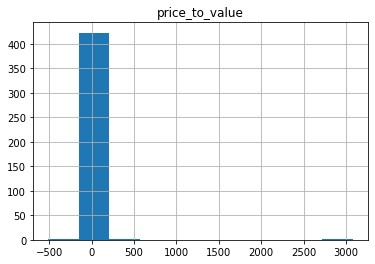

In [11]:
df.hist(column="price_to_value")

### calculate the range

In [12]:
def cut_to(x):
    if x<0:
        return 'less than 0'
    elif x<1:
        return '0-1'
    else:
        return 'larger than 1'

df['valuation_range'] = df['price_to_value'].map(cut_to)

In [13]:
df

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
0,PNR,63.84,34.179709,1.867775,11,Machinery,larger than 1
1,ALLE,133.01,78.805437,1.687828,37,Building Materials,larger than 1
2,ITW,224.03,131.852585,1.699094,45,Machinery,larger than 1
3,AMAT,133.73,101.693333,1.315032,48,Semiconductor Equip,larger than 1
4,NWL,26.76,13.761117,1.944610,52,Household Products,larger than 1
...,...,...,...,...,...,...,...
500,UAL,55.87,-1024.434390,-0.054537,9772,Air Transport,less than 0
501,CDW,184.01,101.858176,1.806531,9829,Computer Services,larger than 1
502,MU,90.66,215.825161,0.420062,9839,Semiconductor,0-1
503,DLTR,117.36,116.664904,1.005958,9850,Retail (General),larger than 1


In [14]:
df['valuation_range'].value_counts()

larger than 1    324
less than 0       64
0-1               55
Name: valuation_range, dtype: int64

## sort

In [15]:
df.sort_values(by=['price_to_value'])

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
385,CCI,179.62,-0.352120,-510.109738,7168,R.E.I.T.,less than 0
407,AVB,189.81,-1.249298,-151.933376,7680,R.E.I.T.,less than 0
5,MAA,151.02,-1.256486,-120.192338,54,R.E.I.T.,less than 0
12,GPN,217.80,-2.308953,-94.328479,149,Information Services,less than 0
263,DTE,140.68,-2.258157,-62.298594,4774,Utility (General),less than 0
...,...,...,...,...,...,...,...
349,NWS,NaN,NaN,NaN,6468,empty,larger than 1
370,AMCR,NaN,NaN,NaN,6912,empty,larger than 1
401,GOOGL,NaN,NaN,NaN,7514,empty,larger than 1
456,CBOE,NaN,NaN,NaN,8855,empty,larger than 1


### select the valuation between 0-1

In [16]:
df = df.loc[df['valuation_range'] == '0-1']
df = df.sort_values(by=['price_to_value'])

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

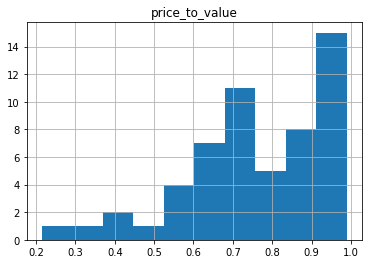

In [17]:
df.hist(column="price_to_value")

In [18]:
df.head(10)

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
14,MAR,148.630,689.341083,0.215612,151,Hotel/Gaming,0-1
138,HLT,128.050,369.749400,0.346316,2632,Hotel/Gaming,0-1
275,FOXA,37.945,100.306176,0.378292,5061,Broadcasting,0-1
502,MU,90.660,215.825161,0.420062,9839,Semiconductor,0-1
489,VIAC,39.350,87.107787,0.451739,9557,Broadcasting,0-1
23,CI,252.570,465.443760,0.542643,344,Healthcare Support Services,0-1
53,PHM,54.220,97.301519,0.557237,1120,Homebuilding,0-1
431,RL,124.560,222.104302,0.560818,8292,Apparel,0-1
362,DHI,96.370,163.917582,0.587917,6698,Homebuilding,0-1
377,ABBV,107.910,178.514367,0.604489,7038,Drugs (Biotechnology),0-1


In [19]:
df.loc[(df['price_to_value']>0.1) & (df['price_to_value']<0.8)]

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
14,MAR,148.630,689.341083,0.215612,151,Hotel/Gaming,0-1
138,HLT,128.050,369.749400,0.346316,2632,Hotel/Gaming,0-1
275,FOXA,37.945,100.306176,0.378292,5061,Broadcasting,0-1
502,MU,90.660,215.825161,0.420062,9839,Semiconductor,0-1
489,VIAC,39.350,87.107787,0.451739,9557,Broadcasting,0-1
23,CI,252.570,465.443760,0.542643,344,Healthcare Support Services,0-1
53,PHM,54.220,97.301519,0.557237,1120,Homebuilding,0-1
431,RL,124.560,222.104302,0.560818,8292,Apparel,0-1
362,DHI,96.370,163.917582,0.587917,6698,Homebuilding,0-1
377,ABBV,107.910,178.514367,0.604489,7038,Drugs (Biotechnology),0-1
